# Environment Setup

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2


## Load Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

D:\CV projects\Traffic_Sign_Recognition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\thraz\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


## Define Directory Paths

In [4]:
train_dir = "C:/Users/thraz/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Train/"
test_dir = "C:/Users/thraz/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1/Test/"

# Preprocess and Augment Data

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- Ensure class folders are sorted numerically ---
def numeric_sort(folder_names):
    return sorted(folder_names, key=lambda x: int(x))

# --- Data augmentation and preprocessing ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

# --- Training generator (uses numeric folder order) ---
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=numeric_sort(os.listdir(train_dir))  # ✅ force numeric order
)

# --- Validation generator ---
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=numeric_sort(os.listdir(train_dir))
)

print("✅ Corrected class indices:", train_generator.class_indices)

# --- Correct label mapping ---
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

# --- Build final mapping for predictions ---
idx_to_label = {i: classes[i] for i in range(len(classes))}

print("\n✅ Final idx_to_label mapping (verified numeric order):")
for k, v in idx_to_label.items():
    print(f"{k}: {v}")

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
✅ Corrected class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '25': 25, '26': 26, '27': 27, '28': 28, '29': 29, '30': 30, '31': 31, '32': 32, '33': 33, '34': 34, '35': 35, '36': 36, '37': 37, '38': 38, '39': 39, '40': 40, '41': 41, '42': 42}

✅ Final idx_to_label mapping (verified numeric order):
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing veh over 3.5 tons
11: Right-of-way at intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Veh > 3.5 tons prohibited
17: No entry
18: General cautio

# Build Transfer Learning Model

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base layers

# Add custom classifier head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(43, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)


# Phase 1: Train classifier head only

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 817s 830ms/step - accuracy: 0.4565 - loss: 1.8827 - val_accuracy: 0.5464 - val_loss: 1.5264
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 813s 828ms/step - accuracy: 0.5961 - loss: 1.2830 - val_accuracy: 0.5819 - val_loss: 1.4403
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 814s 830ms/step - accuracy: 0.6267 - loss: 1.1671 - val_accuracy: 0.5932 - val_loss: 1.3847
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 817s 832ms/step - accuracy: 0.6381 - loss: 1.1335 - val_accuracy: 0.6127 - val_loss: 1.3592
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 820s 836ms/step - accuracy: 0.6466 - loss: 1.1047 - val_accuracy: 0.5826 - val_loss: 1.4300


# Phase 2: Fine-tuning deeper layers

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=5)

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 929s 939ms/step - accuracy: 0.7685 - loss: 0.7267 - val_accuracy: 0.7424 - val_loss: 1.0340
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 919s 936ms/step - accuracy: 0.9000 - loss: 0.2958 - val_accuracy: 0.8065 - val_loss: 0.7389
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 917s 935ms/step - accuracy: 0.9335 - loss: 0.1927 - val_accuracy: 0.8379 - val_loss: 0.5974
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 925s 942ms/step - accuracy: 0.9516 - loss: 0.1450 - val_accuracy: 0.8757 - val_loss: 0.4321
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 917s 935ms/step - accuracy: 0.9620 - loss: 0.1129 - val_accuracy: 0.8610 - val_loss: 0.5383


# Save the Model

In [9]:
model.save("traffic_sign_model.keras")
import os
print(os.path.getsize("traffic_sign_model.keras"))


22509734


# Evaluate the Model

246/246 ━━━━━━━━━━━━━━━━━━━━ 164s 664ms/step

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.83      0.60        42
           1       0.80      0.72      0.76       444
           2       0.80      0.87      0.84       450
           3       0.79      0.87      0.82       282
           4       0.95      0.57      0.71       396
           5       0.70      0.83      0.76       372
           6       0.97      0.99      0.98        84
           7       0.97      0.53      0.69       288
           8       0.56      0.92      0.70       282
           9       0.94      0.92      0.93       294
          10       0.98      0.98      0.98       402
          11       0.92      0.87      0.89       264
          12       0.98      0.99      0.98       420
          13       0.96      1.00      0.98       432
          14       1.00      1.00      1.00       156
          15       0.93      0.90      0.91       126
          

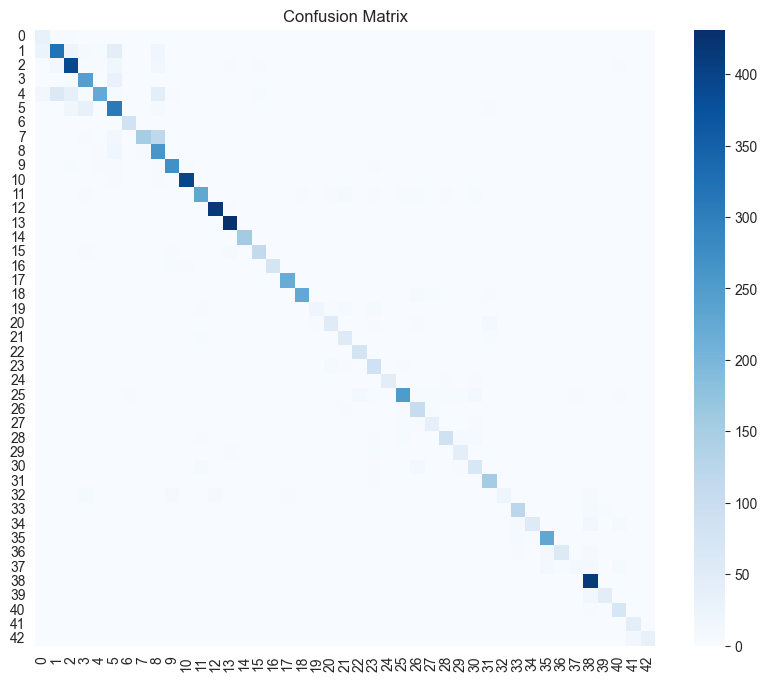

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

print("\n✅ Classification Report:")
print(classification_report(val_generator.classes, y_pred))

cm = confusion_matrix(val_generator.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Confusion Matrix")
plt.show()
